In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import scipy.stats as sts
from scipy.interpolate import griddata
import ipywidgets as widgets
from IPython.display import display
import io
import torch
import torch.nn as nn
import torch.optim as optim
import pickle as pkl
import torch

### CONSTANTS

In [2]:
GENERAL_INPUTS = ["shotnumber", "time"]
MACHINE_INPUTS = ["isbaffled", "ip", "b0", "nel", "ptot", "pdiv", "q95", "betan", "kappa", "deltaavg", "deltaupp",
                  "deltalow", "gapin", "gapout", "zmag", "rmag", "rmin", "lpar_ot", "zeff"]
LABEL = ["LHD_label"]
INPUTS = GENERAL_INPUTS + MACHINE_INPUTS + LABEL
precomputed_dir = 'precomputed_data/'

MAX_SHOT_LENGTH = 11001
input_size = len(MACHINE_INPUTS)
output_size = 4

In [3]:
# Mount MyDrive/QCEH_data/ to fetch training and testing data
from google.colab import drive
drive.mount('/content/drive')
import sys
folder_name = 'drive/MyDrive/QCEH_data/'
sys.path.append(folder_name)
%cd 'drive/MyDrive/QCEH_data/'

parquet_filename = 'TCV_DATAno64467.parquet'

Mounted at /content/drive
/content/drive/MyDrive/QCEH_data


In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
def pad_data(data, to_length, columns=INPUTS):
  # Padd shot' samples with dummy values at the beginning if the shot is too short
  if data.shape[0] < to_length:
    df = pd.DataFrame(0, index=np.arange(to_length - data.shape[0]), columns=columns)
    data = pd.concat([df, data], axis=0, ignore_index=True)
  return data

In [10]:
class LTSMClassifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super().__init__()

        # Defining some parameters
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        #Defining the layers
        # RNN Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.lstm(x, hidden)
        out = out.contiguous().view(-1, self.hidden_dim)

        # Passing trough the dropout layer
        out = self.dropout(out)

        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [11]:
def perform_pca(X, n_components = 2):
    return PCA().fit_transform(X)

def draw_reduced_space(components, s_y, n_components=2, legend_labels = None, legend_title = "LHD Label", title=''):
    """
    Draws reduced data (components) on a 2D graph or 3D depending on the number of components (n_components)
    and displays the labels (s_y)

    legend_labels must be the labels of all the unique values in s_y (increasing order)
    """
    if legend_labels is None:
        legend_mapping = {0: 'Undefined padding mode', 1: 'L-mode', 2: 'QCE H-mode', 3: 'ELMy H-mode'}
        unique_labels = sorted(np.unique(s_y))
        legend_labels = [legend_mapping[label] for label in unique_labels if label in legend_mapping]

        # If there's a label in s_y not in legend_mapping, handle it appropriately
        for label in unique_labels:
            if label not in legend_mapping:
                print(f"Warning: Label {label} is not defined in legend_mapping.")
                legend_labels.append(f"Unknown Label {label}")



    if n_components == 1:
        print("That's not a very interesting plot, go for more than a single component")
        return
        #plt.scatter(components[:,0], range(len(components)), c=s_y)
    elif n_components == 2:
        fig = plt.figure(figsize=(10,5))
        sc = plt.scatter(components[:,0], components[:,1], c=s_y, s=10, alpha=0.5)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
    elif n_components == 3:
        fig = plt.figure(figsize=(10,6))
        ax = fig.add_subplot(projection='3d')
        #ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(components[:,0], components[:,1], components[:,2], c=s_y, s=10, alpha=0.5)
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
        ax.set_box_aspect(aspect=None, zoom=0.85) # otherwise component 3 is cutoff
    else:
        print("That number of components can't be displayed on a graph")

    plt.legend(handles=sc.legend_elements()[0], labels=legend_labels, loc='upper right', title = legend_title)
    plt.title(title, fontsize=12)
    plt.show()

In [12]:
def preprocess(filename):
    df = pd.read_parquet(filename)
    X = df[MACHINE_INPUTS]

    X = torch.tensor(
        pad_data(X, MAX_SHOT_LENGTH, MACHINE_INPUTS).values,
        dtype=torch.float32)

    x_mean = torch.load("x_mean.pt")
    x_std = torch.load("x_std.pt")

    X_standardized = (X - torch.unsqueeze(x_mean, 0)) / torch.unsqueeze(x_std, 0)
    X_standardized = torch.unsqueeze(X_standardized, 0)
    X_standardized = X_standardized.to(device)

    return df, X_standardized, MACHINE_INPUTS


def predict(X):
    model = LTSMClassifier(input_size, output_size, 64, 2, 0.2)
    model.load_state_dict(torch.load("ltsm_2_6_0p2_0p001"))
    model.to(device)
    model.eval()

    outputs = model(X)[0]
    y_predicted = torch.argmax(outputs, dim=1)
    y_predicted = pd.Series(y_predicted.cpu())
    return y_predicted


def show(X, y):
    X_pca = perform_pca(X)
    draw_reduced_space(X_pca[:, :2], y, n_components=2, legend_labels=None, legend_title="LHD Predicted Label", title='2D display of the given shot PCA with predicted labels.')
    draw_reduced_space(X_pca[:, :3], y, n_components=3, legend_labels=None, legend_title="LHD Predicted Label", title='3D display of the given shot PCA with predicted labels.')

def save(df, y):
    y = pd.Series(y)
    y.name = "LHD Predicted Label"
    dataframe = pd.concat([df, y], axis=1)
    dataframe.to_csv('prediction.csv', index=False)
    print('file is saved !')


<ipython-input-13-e6e7c560066c>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


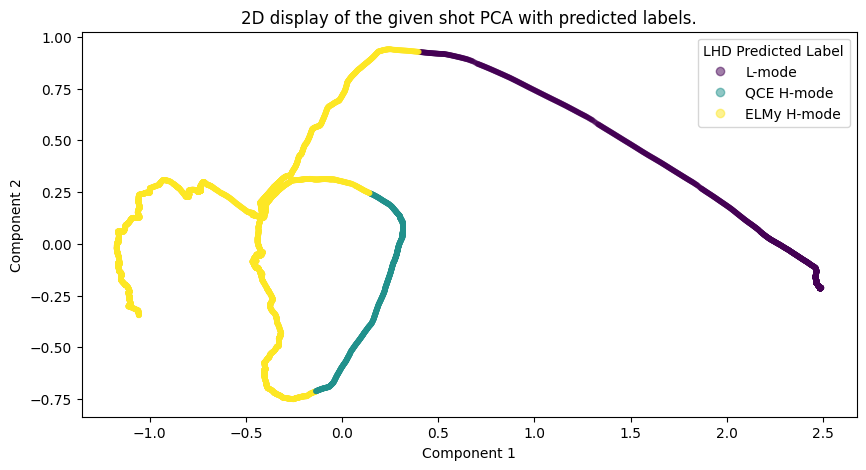

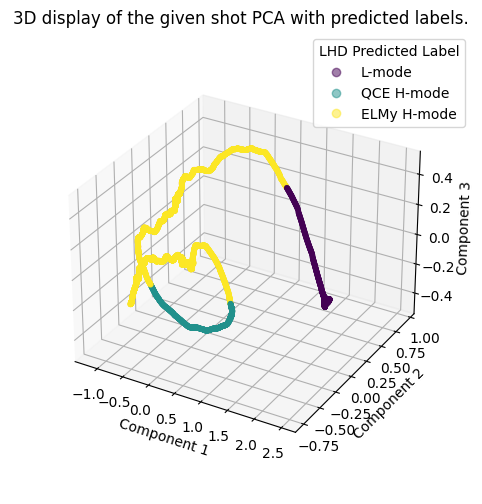

file is saved !


In [13]:
def run(filename):
    df, X, column_names = preprocess(filename)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y = predict(X_tensor)

    nb_padding_features = X.shape[0] - df.shape[0]
    y = y[nb_padding_features:]
    X = X.cpu()[0,nb_padding_features:,:]

    show(X.cpu(), y)
    save(df, y)

run(parquet_filename)